In [1]:
import os
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import time
import pandas as pd
import altair as alt
from ultralytics import YOLO
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
import cv2
import numpy as np
from moviepy.video.io.VideoFileClip import VideoFileClip
from sklearn.model_selection import train_test_split
import gc
import copy
from tqdm import tqdm
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from concurrent.futures import ThreadPoolExecutor
import random
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torchvision.models as models

C:\Users\erick\anaconda3\envs\Yolo\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [3]:
for file in os.listdir('cars'):
    archivo_zip = file
    directorio_destino = 'content'
    nombre_carpeta = archivo_zip.replace('.zip', '')
    ruta_carpeta_extraida = os.path.join(directorio_destino, nombre_carpeta)
    if not os.path.exists(directorio_destino):
        os.makedirs(directorio_destino)

    if not os.path.exists(ruta_carpeta_extraida):
        with zipfile.ZipFile('cars/'+archivo_zip, 'r') as zip_ref:
            zip_ref.extractall(ruta_carpeta_extraida)
        print(f'Archivo {archivo_zip} extraído exitosamente en {ruta_carpeta_extraida}')
    else:
        print(f'Archivo {archivo_zip} ya ha sido extraído anteriormente.')


Archivo CitroenC4Picasso.zip ya ha sido extraído anteriormente.
Archivo KiaSportage.zip ya ha sido extraído anteriormente.
Archivo Mazda3.zip ya ha sido extraído anteriormente.
Archivo MercedesAMG550.zip ya ha sido extraído anteriormente.
Archivo MercedesGLA.zip ya ha sido extraído anteriormente.
Archivo NissanQashqai.zip ya ha sido extraído anteriormente.
Archivo OpelInsignia.zip ya ha sido extraído anteriormente.
Archivo Peugeot208.zip ya ha sido extraído anteriormente.
Archivo Peugeot3008.zip ya ha sido extraído anteriormente.
Archivo Peugeot307.zip ya ha sido extraído anteriormente.
Archivo RenaultCaptur.zip ya ha sido extraído anteriormente.
Archivo RenaultScenic.zip ya ha sido extraído anteriormente.
Archivo VWPassat.zip ya ha sido extraído anteriormente.


In [4]:
dict = {}
for cars in os.listdir('content'):    
    array = []
    for data in os.listdir('content/'+cars):
        if '.txt' in data and data != 'Train_valid_split.txt':
            with open('content/'+cars+'/'+data, 'r') as file:
                line = str(file.readline()).strip('\'').strip('[').strip(']').split(' ')  
                json = {}
                json['speed'] = line[0]
                json['time'] = line[1]
                json['image'] = data.replace('.txt','.MP4')
                array.append(json)
    dict[str(cars)] = array

In [5]:
dataframes = []
for car, records in dict.items():
    df = pd.DataFrame(records)
    df['speed'] = df['speed'].astype(float)
    df['time'] = df['time'].astype(float)
    df['vehicle'] = car
    dataframes.append(df)
df_combined = pd.concat(dataframes, ignore_index=True)


In [6]:
seleccion_vehicle = alt.selection_multi(fields=['vehicle'])
scatter_plot = alt.Chart(df_combined).mark_point(size=60, opacity=0.7).encode(
    x=alt.X('speed', title='Velocidad (km/h)'),
    y=alt.Y('time', title='Tiempo (s)'),
    color=alt.condition(seleccion_vehicle, 'vehicle:N', alt.value('lightgray')),
    tooltip=['vehicle', 'speed', 'time']
).add_selection(
    seleccion_vehicle
).properties(
    title='Relación entre la Velocidad y el Tipo de Vehículo',
    width=800,
    height=400
).configure_axis(
    grid=True
).configure_legend(
    titleFontSize=14,
    labelFontSize=12
).configure_title(
    fontSize=18
)
scatter_plot.display()

alt.Chart(...)

In [7]:
alt.Chart(df_combined).mark_bar().encode(
    x=alt.X('speed', bin=alt.Bin(maxbins=30), title='Velocidad (km/h)'),
    y=alt.Y('count()', title='Contador'),
    column=alt.Column('vehicle', title='vehicle')
).properties(
    width=150,
    height=100,
    title='Distribucion de velocidad por vehicle'
)

alt.Chart(...)

In [8]:
alt.Chart(df_combined).mark_bar().encode(
    x=alt.X('speed', bin=alt.Bin(maxbins=5), title='Velocidad (km/h)'),
    y=alt.Y('count()', title='Contador')
).properties(
    width=150,
    height=100,
    title='Distribucion de velocidad'
)

alt.Chart(...)

In [9]:
correlation_matrix = df_combined[['speed', 'time']].corr()
correlation = correlation_matrix['speed']['time']

scatter_plot = alt.Chart(df_combined).mark_point(filled=True, size=40, opacity=0.5).encode(
    x=alt.X('speed:Q', axis=alt.Axis(title='Velocidad (km/h)')),
    y=alt.Y('time:Q', axis=alt.Axis(title='Tiempo (s)')),
    tooltip=['speed', 'time'],
    color=alt.value('steelblue')
).properties(
    width=500,  # Increased width for better readability
    height=400,  # Adjusted height for a better aspect ratio
    title=alt.TitleParams(f'Correlacion Velocidad vs Tiempo (Correlation: {correlation:.2f})', 
                          fontSize=16, fontWeight='bold', anchor='middle')  # Centered and styled title
)

trendline = alt.Chart(df_combined).transform_regression('speed', 'time').mark_line(color='red', strokeWidth=3).encode(
    x='speed:Q',
    y='time:Q'
)

final_chart = scatter_plot + trendline
final_chart

alt.LayerChart(...)

In [10]:
correlation_matrix = df_combined[['speed', 'time']].corr()
correlation = correlation_matrix['speed']['time']

scatter_plot = alt.Chart(df_combined).mark_point(filled=True, size=40, opacity=0.5).encode(
    x=alt.X('speed:Q', axis=alt.Axis(title='Velocidad (km/h)')),
    y=alt.Y('time:Q', axis=alt.Axis(title='Tiempo (s)')),
    tooltip=['speed', 'time'],
    color=alt.value('steelblue')
).properties(
    width=500,  # Increased width for better readability
    height=400,  # Adjusted height for a better aspect ratio
    title=alt.TitleParams(f'Correlacion Velocidad vs Tiempo (Correlation: {correlation:.2f})', 
                          fontSize=16, fontWeight='bold', anchor='middle')  # Centered and styled title
)

trendline = alt.Chart(df_combined).transform_regression('speed', 'time').mark_line(color='red', strokeWidth=3).encode(
    x='speed:Q',
    y='time:Q'
)

final_chart = scatter_plot + trendline
final_chart

alt.LayerChart(...)

In [11]:
alt.Chart(df_combined).transform_density(
    'speed',
    as_=['speed', 'density'],
    groupby=['vehicle']
).mark_area(orient='horizontal').encode(
    y='speed:Q',
    color='vehicle:N',
    x=alt.X(
        'density:Q',
        stack='center',
        impute=None,
        title=None,
        axis=alt.Axis(labels=False, values=[0], grid=False, ticks=True),
    ),
    column=alt.Column(
        'vehicle:N',
        header=alt.Header(
            titleOrient='bottom',
            labelOrient='bottom',
            labelPadding=0,
        )
    ),
    tooltip=['speed:Q', 'density:Q']
).properties(
    width=100,
    height=300,
    title='Grafico de densidad de velocidad por tiempo'
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
)

alt.Chart(...)

In [12]:
alt.Chart(df_combined.groupby('vehicle')['speed'].mean().reset_index()).mark_bar().encode(
    x=alt.X('vehicle:N', title='Tipo de Vehículo'),
    y=alt.Y('speed:Q', title='Velocidad Media'),
    color='vehicle:N',
    tooltip=['vehicle', 'speed']
).properties(
    title='Comparación de la Velocidad Media de Diferentes Tipos de Vehículos'
)

alt.Chart(...)

In [13]:
alt.Chart(df_combined).mark_boxplot().encode(
    x=alt.X('vehicle:N', title='Tipo de Vehículo'),
    y=alt.Y('speed:Q', title='Velocidad'),
    color='vehicle:N',
    tooltip=['vehicle', 'speed']
).properties(
    title='Distribución de Velocidades por Tipo de Vehículo'
)

alt.Chart(...)

In [14]:
df_combined['time']. min()

4.45

In [15]:
df_combined.tail()

,speed,time,image,vehicle
395,90.0,5.20,VWPassat_90.MP4,VWPassat
396,91.0,5.45,VWPassat_91.MP4,VWPassat
397,94.0,6.00,VWPassat_94.MP4,VWPassat
398,96.0,5.72,VWPassat_96.MP4,VWPassat
399,98.0,5.99,VWPassat_98.MP4,VWPassat


In [16]:
if torch.cuda.is_available():
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    device = 'cuda'
else:
    print("CUDA is not available. Using CPU...")

1
NVIDIA GeForce RTX 4060 Ti


In [17]:
i = 5164
text_content = []
file_name = 'data/speed.txt'
for cars in os.listdir('content'):    
    for data in os.listdir('content/'+cars):
        if '.MP4' in data and i < 2:  
            video = VideoFileClip(f'content/{cars}/{data}')
            second2 = df_combined[df_combined['image'] == data]['time'].values[0] + 1.5
            second1 = second2 - 4.5
            video_cut = video.subclip(second1, second2)
            video_cut.write_videofile(f'data/{data}', codec="libx264")

            text_content.append(str(df_combined[df_combined['image'] == data]['speed'].values[0]) + '\t' + str(df_combined[df_combined['image'] == data]['image'].values[0]) + '\n')
        i += 1
if i < 2:  
    with open(file_name, 'w') as file:
        file.writelines(text_content)

In [18]:
def reproduce_video(video):
    try:
        cap = cv2.VideoCapture(video)
        if not cap.isOpened():
            print(f"Error: Could not open video {video}")
            return
        ret, frame = cap.read()
        if not ret:
            print("Error: Could not read the first frame")
            return
        cv2.imshow('Video', frame)
        print("Press any key to start the video...")
        cv2.waitKey(0)
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            cv2.imshow('Video', frame)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        cap.release()
        cv2.destroyAllWindows()
    
    except Exception as e:
        print("Error:", e)
        if cap:
            cap.release()
        cv2.destroyAllWindows()


In [19]:
def reproduce_video_from_np(frames_np, fps=30):
    delay = int(1000 / fps)
    for frame in frames_np:
        cv2.imshow('Reproduced Video', frame)
        if cv2.waitKey(delay) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()


In [20]:
#reproduce_video('data/VWPassat_85.MP4')

In [21]:
class DataLoaderVideo():
    def __init__(self, path, top_len_dataset=160, height=128, width=128, channels=3):
        self.path = path
        self.height = height
        self.width = width
        self.channels = channels
        self.top_len_dataset = top_len_dataset
        self.data_image = None
        self.data_speed = None
        self.data_real_image = None
        self.data_real_speed = None
        self.input_size = self.height * self.width * self.channels

    def load_dataset(self):
        self.data_image, self.data_speed = self.extract_frames(self.path)

    def get_data_split(self):
        X_train_val, X_test, y_train_val, y_test = train_test_split(self.data_image, self.data_speed, test_size=0.15, random_state=42)
        self.data_real_image = X_test
        self.data_real_speed = y_test
        return train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42)

    def extract_frames(self, path_to_videos):
        video_speed_map = self._load_speed_file(os.path.join(path_to_videos, 'speed.txt'))

        # Randomly choose `top_len_dataset` videos
        video_files = [file for file in os.listdir(path_to_videos) if file.endswith('.MP4')]
        selected_videos = random.sample(video_files, min(self.top_len_dataset, len(video_files)))

        all_frames = []
        all_speeds = []

        # Use a thread pool for parallel video processing
        with ThreadPoolExecutor(max_workers=4) as executor:
            results = list(executor.map(lambda video: self._process_video(video, video_speed_map, path_to_videos), selected_videos))

        for frames, speed in results:
            if frames is not None:
                all_frames.append(frames)
                all_speeds.append(speed)

        return np.array(all_frames), np.array(all_speeds)

    def _load_speed_file(self, speed_file_path):
        video_speed_map = {}
        with open(speed_file_path, 'r') as file:
            for line in file:
                speed, video = line.strip().split('\t')
                video_speed_map[video] = float(speed)
        return video_speed_map

    def _process_video(self, video_file, video_speed_map, path_to_videos, max_frames_per_video=120):
        video_path = os.path.join(path_to_videos, video_file)
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            return None, None

        frames = []
        video_speed = video_speed_map.get(video_file, 0)

        while len(frames) < max_frames_per_video:
            ret, frame = cap.read()
            if not ret:
                break
            frame_resized = cv2.resize(frame, (self.width, self.height))
            frames.append(frame_resized)

        cap.release()
        cv2.destroyAllWindows()

        if len(frames) > max_frames_per_video:
            frames = frames[-max_frames_per_video:]  # Tomar los últimos frames
    
        return np.array(frames), video_speed

In [22]:
data_loader = DataLoaderVideo('data/', top_len_dataset=400, height=160, width=160)
data_loader.load_dataset()

In [23]:
data_loader.data_image.shape

(400, 120, 160, 160, 3)

In [24]:
data_loader.data_speed.shape

(400,)

In [25]:
reproduce_video_from_np(data_loader.data_image[0])

In [26]:
data_loader.data_speed[0]

40.0

In [27]:
data_loader.data_speed[0]

40.0

In [28]:
X_train, X_test, y_train, y_test = data_loader.get_data_split()

In [29]:
data_loader.data_real_image.shape

(60, 120, 160, 160, 3)

In [30]:
X_test.shape

(51, 120, 160, 160, 3)

In [31]:
X_train.shape

(289, 120, 160, 160, 3)

In [32]:
def save_checkpoint(state, filename='checkpoint.pth'):
    torch.save(state, filename)
    print(f"Checkpoint guardado en {filename}")

def load_checkpoint(filename='checkpoint.pth', model=None, optimizer=None):
    """Cargar el estado del modelo y el optimizador desde un archivo de checkpoint"""
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        best_val_loss = checkpoint['best_val_loss']
        print(f"Checkpoint cargado desde {filename}. Reanudar desde la época {epoch}.")
        return epoch, best_val_loss
    else:
        print(f"No se encontró el archivo {filename}. Empezando desde la época 0.")
        return 0, float('inf')  # Iniciar desde la época 0 y con la mejor pérdida infinita

In [33]:
class CNN3D(nn.Module):
    def __init__(self, learning_rate=0.0001):
        super(CNN3D, self).__init__()
        self.model = nn.Sequential(
            nn.Conv3d(in_channels=3, out_channels=32, kernel_size=(3, 3, 3), padding=1),  # padding=1 for 'same'
            nn.BatchNorm3d(32),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=(3, 3, 3), padding=1),
            
            nn.Conv3d(in_channels=32, out_channels=32, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=(3, 3, 3), padding=1),
            
            nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=(3, 3, 3), padding=1),
            
            nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=(3, 3, 3), padding=1),

            nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(3, 3, 3), padding=1),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=(3, 3, 3), padding=1),

            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, video_frames):
        x = self.model(video_frames)
        print(f"Shape before flatten: {x.shape}")  # Print shape before flattening
        x = self.fc(x)
        return x


In [34]:
class ListModule(nn.Module):
    def __init__(self, model_name):
        super(ListModule, self).__init__()
        
        if model_name == "ResNet3D":
            self.model = models.video.r3d_18(pretrained=True)
            num_ftrs = self.model.fc.in_features
            self.model.fc =nn.Sequential(
                nn.Linear(num_ftrs, 32),
                nn.ReLU(),
                nn.Linear(32, 1)
            )

        elif model_name == "MC3_18":
            self.model = models.video.mc3_18(pretrained=True)
            num_ftrs = self.model.fc.in_features
            self.model.fc =nn.Sequential(
                nn.Linear(num_ftrs, 32),
                nn.ReLU(),
                nn.Linear(32, 1)
            )
        elif model_name == "R2Plus1D":
            self.model = models.video.r2plus1d_18(pretrained=True)
            num_ftrs = self.model.fc.in_features
            self.model.fc =nn.Sequential(
                nn.Linear(num_ftrs, 32),
                nn.ReLU(),
                nn.Linear(32, 1)
            )

        elif model_name == "CNN3D":
            self.model = nn.Sequential(
                nn.Conv3d(in_channels=3, out_channels=32, kernel_size=(3, 3, 3), padding=1),  # padding=1 for 'same'
                nn.BatchNorm3d(32),
                nn.LeakyReLU(),
                nn.MaxPool3d(kernel_size=(3, 3, 3), padding=1),
            
                nn.Conv3d(in_channels=32, out_channels=32, kernel_size=(3, 3, 3), padding=1),
                nn.BatchNorm3d(32),
                nn.LeakyReLU(),
                nn.MaxPool3d(kernel_size=(3, 3, 3), padding=1),
            
                nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(3, 3, 3), padding=1),
                nn.BatchNorm3d(64),
                nn.LeakyReLU(),
                nn.MaxPool3d(kernel_size=(3, 3, 3), padding=1),
            
                nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(3, 3, 3), padding=1),
                nn.BatchNorm3d(64),
                nn.LeakyReLU(),
                nn.MaxPool3d(kernel_size=(3, 3, 3), padding=1),

                nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(3, 3, 3), padding=1),
                nn.LeakyReLU(),
                nn.MaxPool3d(kernel_size=(3, 3, 3), padding=1),

                nn.Flatten()
            )
            self.model.fc = nn.Sequential(
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 1)
            )
            

    def forward(self, x):
        x = self.model(x)
        return x

In [35]:
def train_and_validate_model(model, train_loader, test_loader, input_size, output_size, batch_size=32, num_epochs=10, patience=20, learning_rate=0.01 , model_name="best_model.pth", checkpoint_path="checkpoint.pth"):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience)
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict()) 
    epochs_no_improve = 0

    start_epoch, best_val_loss = load_checkpoint(checkpoint_path, model, optimizer)


    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                train_output = model(X_batch)
                loss = criterion(train_output, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * X_batch.size(0)
                pbar.set_postfix({'Train Loss': train_loss / len(train_loader.dataset)})
                pbar.update(1)
        
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            with tqdm(total=len(test_loader), desc=f'Validation {epoch+1}/{num_epochs}', unit='batch') as pbar_val:
                for X_batch, y_batch in test_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    test_output = model(X_batch)
                    loss = criterion(test_output, y_batch)
                    val_loss += loss.item() * X_batch.size(0)
                    pbar_val.update(1)
        
        val_loss /= len(test_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        scheduler.step(val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            #save_checkpoint({'epoch': epoch + 1,'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(),'best_val_loss': best_val_loss}, filename=checkpoint_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    
    model.load_state_dict(best_model_wts)
    return model, best_val_loss, train_losses, val_losses


In [36]:
lr = 0.00003
output_size = 1 
batch_size = 6
num_epochs = 120
#models_train = [ 'R2Plus1D', 'CNN3D', 'MC3_18', 'ResNet3D']
models_train = ['CNN3D']

In [37]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 4, 1, 2, 3)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 4, 1, 2, 3)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [38]:
for X_batch, y_batch in train_loader:
    print(X_batch.shape, y_batch.shape)
    #model = CNN3D()
    #model.to(device)
    #model(X_batch.to(device))
    break

torch.Size([6, 3, 120, 160, 160]) torch.Size([6, 1])


In [39]:
best_model = None
best_val_loss = float('inf')
train_losses_dict = {}
val_losses_dict = {}
for model_train in models_train:
    model = ListModule(model_train)
    model_name = f'model_{model_train}.pth'
    checkpoint_path = f'model_lr{model_train}.pth'

    model, val_loss, train_losses, val_losses = train_and_validate_model(model , train_loader, test_loader, data_loader.input_size,output_size, batch_size,num_epochs, learning_rate=lr, model_name=model_name, checkpoint_path=checkpoint_path)
    torch.save(model.state_dict(), f'model_{model_train}.pth')
    train_losses_dict[model_train] = train_losses
    val_losses_dict[model_train] = val_losses
    del model    
    optimizer = None
    torch.cuda.empty_cache()
    gc.collect()
    


No se encontró el archivo model_lrCNN3D.pth. Empezando desde la época 0.


Validation 1/120: 100%|██████████| 9/9 [00:01<00:00,  5.18batch/s]


Epoch [1/120], Training Loss: 4859.5042, Validation Loss: 4704.3702


Validation 2/120: 100%|██████████| 9/9 [00:01<00:00,  6.01batch/s]


Epoch [2/120], Training Loss: 4716.8499, Validation Loss: 4535.2364


Validation 3/120: 100%|██████████| 9/9 [00:01<00:00,  6.34batch/s]


Epoch [3/120], Training Loss: 4516.0074, Validation Loss: 4329.7618


Validation 4/120: 100%|██████████| 9/9 [00:01<00:00,  6.45batch/s]


Epoch [4/120], Training Loss: 4224.1988, Validation Loss: 3966.0092


Validation 5/120: 100%|██████████| 9/9 [00:01<00:00,  6.41batch/s]


Epoch [5/120], Training Loss: 3849.6745, Validation Loss: 3600.4919


Validation 6/120: 100%|██████████| 9/9 [00:01<00:00,  6.42batch/s]


Epoch [6/120], Training Loss: 3422.9023, Validation Loss: 3186.6880


Validation 7/120: 100%|██████████| 9/9 [00:01<00:00,  6.40batch/s]


Epoch [7/120], Training Loss: 2951.0050, Validation Loss: 2776.3659


Validation 8/120: 100%|██████████| 9/9 [00:01<00:00,  5.80batch/s]


Epoch [8/120], Training Loss: 2466.9956, Validation Loss: 2363.1971


Validation 9/120: 100%|██████████| 9/9 [00:01<00:00,  6.30batch/s]


Epoch [9/120], Training Loss: 1989.3441, Validation Loss: 1719.7458


Validation 10/120: 100%|██████████| 9/9 [00:01<00:00,  6.43batch/s]


Epoch [10/120], Training Loss: 1557.8838, Validation Loss: 1473.0695


Validation 11/120: 100%|██████████| 9/9 [00:01<00:00,  6.40batch/s]


Epoch [11/120], Training Loss: 1193.4933, Validation Loss: 1159.9838


Validation 12/120: 100%|██████████| 9/9 [00:01<00:00,  6.42batch/s]


Epoch [12/120], Training Loss: 905.3197, Validation Loss: 785.9543


Validation 13/120: 100%|██████████| 9/9 [00:01<00:00,  6.46batch/s]


Epoch [13/120], Training Loss: 683.4414, Validation Loss: 714.3386


Validation 14/120: 100%|██████████| 9/9 [00:01<00:00,  6.45batch/s]


Epoch [14/120], Training Loss: 519.0851, Validation Loss: 531.0987


Validation 15/120: 100%|██████████| 9/9 [00:01<00:00,  6.45batch/s]


Epoch [15/120], Training Loss: 409.3399, Validation Loss: 471.2089


Validation 16/120: 100%|██████████| 9/9 [00:01<00:00,  6.42batch/s]


Epoch [16/120], Training Loss: 333.8661, Validation Loss: 353.0193


Validation 17/120: 100%|██████████| 9/9 [00:01<00:00,  6.48batch/s]


Epoch [17/120], Training Loss: 276.7242, Validation Loss: 364.6090


Validation 18/120: 100%|██████████| 9/9 [00:01<00:00,  6.41batch/s]


Epoch [18/120], Training Loss: 217.1295, Validation Loss: 244.2418


Validation 19/120: 100%|██████████| 9/9 [00:01<00:00,  6.43batch/s]


Epoch [19/120], Training Loss: 188.2528, Validation Loss: 229.6442


Validation 20/120: 100%|██████████| 9/9 [00:01<00:00,  6.43batch/s]


Epoch [20/120], Training Loss: 164.4460, Validation Loss: 203.6137


Validation 21/120: 100%|██████████| 9/9 [00:01<00:00,  6.42batch/s]


Epoch [21/120], Training Loss: 140.4884, Validation Loss: 349.0095


Validation 22/120: 100%|██████████| 9/9 [00:01<00:00,  6.41batch/s]


Epoch [22/120], Training Loss: 113.0508, Validation Loss: 148.0665


Validation 23/120: 100%|██████████| 9/9 [00:01<00:00,  6.39batch/s]


Epoch [23/120], Training Loss: 92.2012, Validation Loss: 181.9901


Validation 24/120: 100%|██████████| 9/9 [00:01<00:00,  6.42batch/s]


Epoch [24/120], Training Loss: 89.1637, Validation Loss: 109.4131


Validation 25/120: 100%|██████████| 9/9 [00:01<00:00,  6.41batch/s]


Epoch [25/120], Training Loss: 65.7847, Validation Loss: 102.1538


Validation 26/120: 100%|██████████| 9/9 [00:01<00:00,  6.49batch/s]


Epoch [26/120], Training Loss: 73.1413, Validation Loss: 91.3798


Validation 27/120: 100%|██████████| 9/9 [00:01<00:00,  6.47batch/s]


Epoch [27/120], Training Loss: 68.9357, Validation Loss: 87.8774


Validation 28/120: 100%|██████████| 9/9 [00:01<00:00,  6.52batch/s]


Epoch [28/120], Training Loss: 50.4489, Validation Loss: 69.5417


Validation 29/120: 100%|██████████| 9/9 [00:01<00:00,  6.56batch/s]


Epoch [29/120], Training Loss: 44.3572, Validation Loss: 67.5374


Validation 30/120: 100%|██████████| 9/9 [00:01<00:00,  6.52batch/s]


Epoch [30/120], Training Loss: 50.9903, Validation Loss: 72.4612


Validation 31/120: 100%|██████████| 9/9 [00:01<00:00,  6.52batch/s]


Epoch [31/120], Training Loss: 39.8714, Validation Loss: 84.9117


Validation 32/120: 100%|██████████| 9/9 [00:01<00:00,  6.41batch/s]


Epoch [32/120], Training Loss: 40.8026, Validation Loss: 68.1840


Validation 33/120: 100%|██████████| 9/9 [00:01<00:00,  6.55batch/s]


Epoch [33/120], Training Loss: 41.6621, Validation Loss: 119.3089


Validation 34/120: 100%|██████████| 9/9 [00:01<00:00,  6.52batch/s]


Epoch [34/120], Training Loss: 38.6557, Validation Loss: 69.7300


Validation 35/120: 100%|██████████| 9/9 [00:01<00:00,  6.54batch/s]


Epoch [35/120], Training Loss: 34.4481, Validation Loss: 46.2514


Validation 36/120: 100%|██████████| 9/9 [00:01<00:00,  6.46batch/s]


Epoch [36/120], Training Loss: 30.5240, Validation Loss: 85.2665


Validation 37/120: 100%|██████████| 9/9 [00:01<00:00,  6.51batch/s]


Epoch [37/120], Training Loss: 28.5070, Validation Loss: 51.1159


Validation 38/120: 100%|██████████| 9/9 [00:01<00:00,  6.44batch/s]


Epoch [38/120], Training Loss: 28.3894, Validation Loss: 61.1686


Validation 39/120: 100%|██████████| 9/9 [00:01<00:00,  6.62batch/s]


Epoch [39/120], Training Loss: 30.0659, Validation Loss: 65.6407


Validation 40/120: 100%|██████████| 9/9 [00:01<00:00,  6.50batch/s]


Epoch [40/120], Training Loss: 30.6985, Validation Loss: 41.9504


Validation 41/120: 100%|██████████| 9/9 [00:01<00:00,  6.47batch/s]


Epoch [41/120], Training Loss: 26.8465, Validation Loss: 38.1966


Validation 42/120: 100%|██████████| 9/9 [00:01<00:00,  6.55batch/s]


Epoch [42/120], Training Loss: 23.2922, Validation Loss: 43.3767


Validation 43/120: 100%|██████████| 9/9 [00:01<00:00,  6.56batch/s]


Epoch [43/120], Training Loss: 28.1564, Validation Loss: 56.6949


Validation 44/120: 100%|██████████| 9/9 [00:01<00:00,  6.56batch/s]


Epoch [44/120], Training Loss: 24.2511, Validation Loss: 103.7514


Validation 45/120: 100%|██████████| 9/9 [00:01<00:00,  6.49batch/s]


Epoch [45/120], Training Loss: 17.8540, Validation Loss: 31.6363


Validation 46/120: 100%|██████████| 9/9 [00:01<00:00,  6.53batch/s]


Epoch [46/120], Training Loss: 17.5203, Validation Loss: 40.1339


Validation 47/120: 100%|██████████| 9/9 [00:01<00:00,  6.57batch/s]


Epoch [47/120], Training Loss: 17.1815, Validation Loss: 53.8877


Validation 48/120: 100%|██████████| 9/9 [00:01<00:00,  6.47batch/s]


Epoch [48/120], Training Loss: 25.7136, Validation Loss: 97.0548


Validation 49/120: 100%|██████████| 9/9 [00:01<00:00,  6.54batch/s]


Epoch [49/120], Training Loss: 17.2402, Validation Loss: 60.3203


Validation 50/120: 100%|██████████| 9/9 [00:01<00:00,  6.27batch/s]


Epoch [50/120], Training Loss: 16.7100, Validation Loss: 50.7727


Validation 51/120: 100%|██████████| 9/9 [00:01<00:00,  6.14batch/s]


Epoch [51/120], Training Loss: 17.7200, Validation Loss: 33.1155


Validation 52/120: 100%|██████████| 9/9 [00:01<00:00,  6.25batch/s]


Epoch [52/120], Training Loss: 15.7409, Validation Loss: 29.0580


Validation 53/120: 100%|██████████| 9/9 [00:01<00:00,  6.37batch/s]


Epoch [53/120], Training Loss: 17.7448, Validation Loss: 27.7885


Validation 54/120: 100%|██████████| 9/9 [00:01<00:00,  6.36batch/s]


Epoch [54/120], Training Loss: 13.2259, Validation Loss: 29.4933


Validation 55/120: 100%|██████████| 9/9 [00:01<00:00,  6.25batch/s]


Epoch [55/120], Training Loss: 12.7159, Validation Loss: 41.8026


Validation 56/120: 100%|██████████| 9/9 [00:01<00:00,  6.25batch/s]


Epoch [56/120], Training Loss: 12.5136, Validation Loss: 30.0406


Validation 57/120: 100%|██████████| 9/9 [00:01<00:00,  6.26batch/s]


Epoch [57/120], Training Loss: 14.5130, Validation Loss: 70.9437


Validation 58/120: 100%|██████████| 9/9 [00:01<00:00,  6.40batch/s]


Epoch [58/120], Training Loss: 20.1618, Validation Loss: 31.8061


Validation 59/120: 100%|██████████| 9/9 [00:01<00:00,  6.20batch/s]


Epoch [59/120], Training Loss: 14.2447, Validation Loss: 47.4105


Validation 60/120: 100%|██████████| 9/9 [00:01<00:00,  6.24batch/s]


Epoch [60/120], Training Loss: 9.2808, Validation Loss: 28.2446


Validation 61/120: 100%|██████████| 9/9 [00:01<00:00,  6.26batch/s]


Epoch [61/120], Training Loss: 12.9301, Validation Loss: 29.7178


Validation 62/120: 100%|██████████| 9/9 [00:01<00:00,  6.31batch/s]


Epoch [62/120], Training Loss: 10.4623, Validation Loss: 47.7420


Validation 63/120: 100%|██████████| 9/9 [00:01<00:00,  6.47batch/s]


Epoch [63/120], Training Loss: 9.8627, Validation Loss: 26.4868


Validation 64/120: 100%|██████████| 9/9 [00:01<00:00,  6.48batch/s]


Epoch [64/120], Training Loss: 13.1508, Validation Loss: 24.5620


Validation 65/120: 100%|██████████| 9/9 [00:01<00:00,  6.16batch/s]


Epoch [65/120], Training Loss: 8.4804, Validation Loss: 31.8804


Validation 66/120: 100%|██████████| 9/9 [00:01<00:00,  6.30batch/s]


Epoch [66/120], Training Loss: 9.8138, Validation Loss: 38.5722


Validation 67/120: 100%|██████████| 9/9 [00:01<00:00,  6.50batch/s]


Epoch [67/120], Training Loss: 9.7220, Validation Loss: 42.5297


Validation 68/120: 100%|██████████| 9/9 [00:01<00:00,  6.42batch/s]


Epoch [68/120], Training Loss: 7.9894, Validation Loss: 64.9550


Validation 69/120: 100%|██████████| 9/9 [00:01<00:00,  6.26batch/s]


Epoch [69/120], Training Loss: 13.5443, Validation Loss: 53.5236


Validation 70/120: 100%|██████████| 9/9 [00:01<00:00,  6.24batch/s]


Epoch [70/120], Training Loss: 11.6911, Validation Loss: 30.7865


Validation 71/120: 100%|██████████| 9/9 [00:01<00:00,  6.30batch/s]


Epoch [71/120], Training Loss: 8.8903, Validation Loss: 39.2372


Validation 72/120: 100%|██████████| 9/9 [00:01<00:00,  6.48batch/s]


Epoch [72/120], Training Loss: 6.1811, Validation Loss: 28.2827


Validation 73/120: 100%|██████████| 9/9 [00:01<00:00,  6.44batch/s]


Epoch [73/120], Training Loss: 7.1057, Validation Loss: 23.1898


Validation 74/120: 100%|██████████| 9/9 [00:01<00:00,  6.30batch/s]


Epoch [74/120], Training Loss: 6.3662, Validation Loss: 24.3965


Validation 75/120: 100%|██████████| 9/9 [00:01<00:00,  6.28batch/s]


Epoch [75/120], Training Loss: 9.3429, Validation Loss: 24.5121


Validation 76/120: 100%|██████████| 9/9 [00:01<00:00,  6.51batch/s]


Epoch [76/120], Training Loss: 8.0985, Validation Loss: 27.6283


Validation 77/120: 100%|██████████| 9/9 [00:01<00:00,  6.41batch/s]


Epoch [77/120], Training Loss: 5.1742, Validation Loss: 36.5810


Validation 78/120: 100%|██████████| 9/9 [00:01<00:00,  6.43batch/s]


Epoch [78/120], Training Loss: 7.2017, Validation Loss: 52.9366


Validation 79/120: 100%|██████████| 9/9 [00:01<00:00,  6.50batch/s]


Epoch [79/120], Training Loss: 6.9043, Validation Loss: 28.4014


Validation 80/120: 100%|██████████| 9/9 [00:01<00:00,  6.50batch/s]


Epoch [80/120], Training Loss: 4.3835, Validation Loss: 32.0484


Validation 81/120: 100%|██████████| 9/9 [00:01<00:00,  6.51batch/s]


Epoch [81/120], Training Loss: 6.5440, Validation Loss: 28.2287


Validation 82/120: 100%|██████████| 9/9 [00:01<00:00,  6.56batch/s]


Epoch [82/120], Training Loss: 7.6258, Validation Loss: 28.5668


Validation 83/120: 100%|██████████| 9/9 [00:01<00:00,  6.52batch/s]


Epoch [83/120], Training Loss: 5.3349, Validation Loss: 23.4518


Validation 84/120: 100%|██████████| 9/9 [00:01<00:00,  6.54batch/s]


Epoch [84/120], Training Loss: 8.1811, Validation Loss: 24.6550


Validation 85/120: 100%|██████████| 9/9 [00:01<00:00,  6.53batch/s]


Epoch [85/120], Training Loss: 6.5440, Validation Loss: 41.4892


Validation 86/120: 100%|██████████| 9/9 [00:01<00:00,  6.49batch/s]


Epoch [86/120], Training Loss: 4.9193, Validation Loss: 22.6515


Validation 87/120: 100%|██████████| 9/9 [00:01<00:00,  6.55batch/s]


Epoch [87/120], Training Loss: 6.2419, Validation Loss: 23.0987


Validation 88/120: 100%|██████████| 9/9 [00:01<00:00,  6.56batch/s]


Epoch [88/120], Training Loss: 3.9909, Validation Loss: 21.7451


Validation 89/120: 100%|██████████| 9/9 [00:01<00:00,  6.49batch/s]


Epoch [89/120], Training Loss: 4.2554, Validation Loss: 21.5785


Validation 90/120: 100%|██████████| 9/9 [00:01<00:00,  6.52batch/s]


Epoch [90/120], Training Loss: 4.9678, Validation Loss: 36.3716


Validation 91/120: 100%|██████████| 9/9 [00:01<00:00,  6.47batch/s]


Epoch [91/120], Training Loss: 2.2654, Validation Loss: 31.3573


Validation 92/120: 100%|██████████| 9/9 [00:01<00:00,  6.47batch/s]


Epoch [92/120], Training Loss: 3.9053, Validation Loss: 25.3688


Validation 93/120: 100%|██████████| 9/9 [00:01<00:00,  6.47batch/s]


Epoch [93/120], Training Loss: 5.9985, Validation Loss: 37.1817


Validation 94/120: 100%|██████████| 9/9 [00:01<00:00,  6.55batch/s]


Epoch [94/120], Training Loss: 6.5055, Validation Loss: 41.1664


Validation 95/120: 100%|██████████| 9/9 [00:01<00:00,  6.50batch/s]


Epoch [95/120], Training Loss: 4.7972, Validation Loss: 22.7545


Validation 96/120: 100%|██████████| 9/9 [00:01<00:00,  6.46batch/s]


Epoch [96/120], Training Loss: 4.3455, Validation Loss: 29.2574


Validation 97/120: 100%|██████████| 9/9 [00:01<00:00,  6.59batch/s]


Epoch [97/120], Training Loss: 3.6829, Validation Loss: 35.3106


Validation 98/120: 100%|██████████| 9/9 [00:01<00:00,  6.58batch/s]


Epoch [98/120], Training Loss: 4.0883, Validation Loss: 38.0353


Validation 99/120: 100%|██████████| 9/9 [00:01<00:00,  6.47batch/s]


Epoch [99/120], Training Loss: 3.6464, Validation Loss: 21.3115


Validation 100/120: 100%|██████████| 9/9 [00:01<00:00,  6.46batch/s]


Epoch [100/120], Training Loss: 4.7388, Validation Loss: 42.7831


Validation 101/120: 100%|██████████| 9/9 [00:01<00:00,  6.54batch/s]


Epoch [101/120], Training Loss: 3.2298, Validation Loss: 31.0647


Validation 102/120: 100%|██████████| 9/9 [00:01<00:00,  6.43batch/s]


Epoch [102/120], Training Loss: 3.8408, Validation Loss: 58.8169


Validation 103/120: 100%|██████████| 9/9 [00:01<00:00,  6.52batch/s]


Epoch [103/120], Training Loss: 4.1554, Validation Loss: 27.0436


Validation 104/120: 100%|██████████| 9/9 [00:01<00:00,  6.58batch/s]


Epoch [104/120], Training Loss: 4.0482, Validation Loss: 23.4978


Validation 105/120: 100%|██████████| 9/9 [00:01<00:00,  6.40batch/s]


Epoch [105/120], Training Loss: 4.1502, Validation Loss: 20.9122


Validation 106/120: 100%|██████████| 9/9 [00:01<00:00,  6.51batch/s]


Epoch [106/120], Training Loss: 3.4473, Validation Loss: 37.7730


Validation 107/120: 100%|██████████| 9/9 [00:01<00:00,  6.56batch/s]


Epoch [107/120], Training Loss: 3.9577, Validation Loss: 22.0415


Validation 108/120: 100%|██████████| 9/9 [00:01<00:00,  6.51batch/s]


Epoch [108/120], Training Loss: 2.3821, Validation Loss: 25.4017


Validation 109/120: 100%|██████████| 9/9 [00:01<00:00,  6.46batch/s]


Epoch [109/120], Training Loss: 3.4294, Validation Loss: 44.4390


Validation 110/120: 100%|██████████| 9/9 [00:01<00:00,  6.38batch/s]


Epoch [110/120], Training Loss: 5.0282, Validation Loss: 52.4260


Validation 111/120: 100%|██████████| 9/9 [00:01<00:00,  6.52batch/s]


Epoch [111/120], Training Loss: 4.2927, Validation Loss: 21.7550


Validation 112/120: 100%|██████████| 9/9 [00:01<00:00,  6.33batch/s]


Epoch [112/120], Training Loss: 4.1939, Validation Loss: 27.9852


Validation 113/120: 100%|██████████| 9/9 [00:01<00:00,  6.35batch/s]


Epoch [113/120], Training Loss: 3.3483, Validation Loss: 21.0217


Validation 114/120: 100%|██████████| 9/9 [00:01<00:00,  6.27batch/s]


Epoch [114/120], Training Loss: 3.4587, Validation Loss: 22.2479


Validation 115/120: 100%|██████████| 9/9 [00:01<00:00,  6.37batch/s]


Epoch [115/120], Training Loss: 3.3747, Validation Loss: 21.5123


Validation 116/120: 100%|██████████| 9/9 [00:01<00:00,  6.45batch/s]


Epoch [116/120], Training Loss: 3.6524, Validation Loss: 24.2784


Validation 117/120: 100%|██████████| 9/9 [00:01<00:00,  6.43batch/s]


Epoch [117/120], Training Loss: 2.6364, Validation Loss: 22.0651


Validation 118/120: 100%|██████████| 9/9 [00:01<00:00,  6.53batch/s]


Epoch [118/120], Training Loss: 1.7657, Validation Loss: 35.4503


Validation 119/120: 100%|██████████| 9/9 [00:01<00:00,  6.41batch/s]


Epoch [119/120], Training Loss: 4.5148, Validation Loss: 27.5212


Validation 120/120: 100%|██████████| 9/9 [00:01<00:00,  6.41batch/s]


Epoch [120/120], Training Loss: 4.1998, Validation Loss: 25.1251


In [40]:
import json
with open(f'model_{model_train}_train_loss.json', 'w') as f:
    json.dump(train_losses_dict, f)
with open(f'model_{model_train}_test_loss.json', 'w') as f:
    json.dump(val_losses_dict, f)

In [41]:
for model_load in model_train:
    with open(f'model_{model_train}_train_loss.json', 'r') as f:
        train_losses_dict_read = json.load(f)

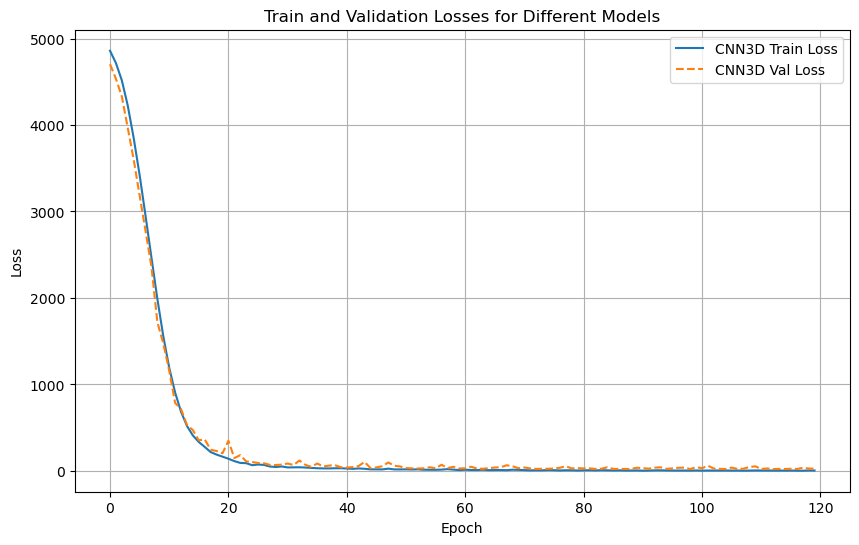

In [42]:
plt.figure(figsize=(10, 6))
for model_name, losses in train_losses_dict.items():
    plt.plot(losses, label=f'{model_name} Train Loss')
for model_name, losses in val_losses_dict.items():
    plt.plot(losses, label=f'{model_name} Val Loss', linestyle='--')
plt.title('Train and Validation Losses for Different Models')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
for model_name, losses in val_losses_dict.items():
    print(model_name, min(losses))

CNN3D 20.912152262294995


In [44]:
torch.cuda.empty_cache()
gc.collect()

3910

In [45]:
data_loader.data_real_image[0].shape

(120, 160, 160, 3)

In [46]:
best_model = ListModule('CNN3D')
best_model.to(device)
best_model.load_state_dict(torch.load('model_CNN3D.pth'))
best_model.eval()

ListModule(
  (model): Sequential(
    (0): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool3d(kernel_size=(3, 3, 3), stride=(3, 3, 3), padding=1, dilation=1, ceil_mode=False)
    (4): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool3d(kernel_size=(3, 3, 3), stride=(3, 3, 3), padding=1, dilation=1, ceil_mode=False)
    (8): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (9): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): MaxPool3d(kernel_size=(3, 3, 3), stride=(3, 3, 3), padding=1, dilation=1, ceil_mode=False)
    (12): Conv3d(64, 64, 

In [47]:
# La permutación correcta para reorganizar las dimensiones
eval_data = torch.tensor(data_loader.data_real_image[0:8], dtype=torch.float32).permute(0, 4, 1, 2, 3).to(device)
with torch.no_grad():
    test_output = best_model(eval_data)
torch.round(test_output).int()

tensor([[84],
        [73],
        [46],
        [57],
        [75],
        [83],
        [78],
        [67]], device='cuda:0', dtype=torch.int32)

In [48]:
data_loader.data_real_speed[0:8]

array([         90,          73,          47,          54,          73,          82,          74,          68])

In [49]:
eval_data = torch.tensor(data_loader.data_real_image[-1], dtype=torch.float32).permute(3, 0, 1, 2).unsqueeze(0).to(device)
with torch.no_grad():
    test_output = best_model(eval_data)
torch.round(test_output).int()

tensor([[41]], device='cuda:0', dtype=torch.int32)

In [50]:
data_loader.data_real_speed[-1]

33.0

In [86]:
all_real_speeds = []
all_predicted_speeds = []
for i in range(0, len(data_loader.data_real_image), 6):
    eval_data = torch.tensor(data_loader.data_real_image[i:i+6], dtype=torch.float32).permute(0, 4, 1, 2, 3).to(device)
    with torch.no_grad():
        test_output = best_model(eval_data)
    predicted_speed = torch.round(test_output).int().cpu().squeeze()
    real_speed = torch.tensor(data_loader.data_real_speed[i:i+6])  # Ensure real_speed is a tensor
    predicted_speed = predicted_speed.view(-1)
    real_speed = real_speed.view(-1)
    mask = torch.abs(real_speed - predicted_speed) <= 10
    all_real_speeds.extend(real_speed[mask].tolist())
    all_predicted_speeds.extend(predicted_speed[mask].tolist())
all_real_speeds = torch.tensor(all_real_speeds)
all_predicted_speeds = torch.tensor(all_predicted_speeds).squeeze()
comparison = torch.stack([all_real_speeds, all_predicted_speeds], dim=1)
print("Real vs Generado (Velocidades):")
print(comparison)

Real vs Generado (Velocidades):
tensor([[ 90.,  84.],
        [ 73.,  73.],
        [ 47.,  46.],
        [ 54.,  57.],
        [ 73.,  75.],
        [ 82.,  83.],
        [ 74.,  78.],
        [ 68.,  67.],
        [ 98., 100.],
        [ 83.,  85.],
        [ 91.,  92.],
        [ 47.,  50.],
        [ 40.,  40.],
        [ 88.,  88.],
        [ 78.,  74.],
        [ 44.,  45.],
        [ 48.,  48.],
        [ 60.,  56.],
        [ 66.,  71.],
        [ 80.,  82.],
        [100.,  98.],
        [ 88.,  89.],
        [ 64.,  68.],
        [ 61.,  64.],
        [ 40.,  43.],
        [ 88.,  88.],
        [ 94.,  97.],
        [ 92.,  90.],
        [ 94.,  92.],
        [ 86.,  85.],
        [ 44.,  43.],
        [ 70.,  71.],
        [ 78.,  78.],
        [ 96.,  92.],
        [ 75.,  71.],
        [ 63.,  68.],
        [ 42.,  44.],
        [ 98.,  92.],
        [ 67.,  65.],
        [ 75.,  76.],
        [ 76.,  72.],
        [ 48.,  47.],
        [ 41.,  39.],
        [ 31.,  38.],


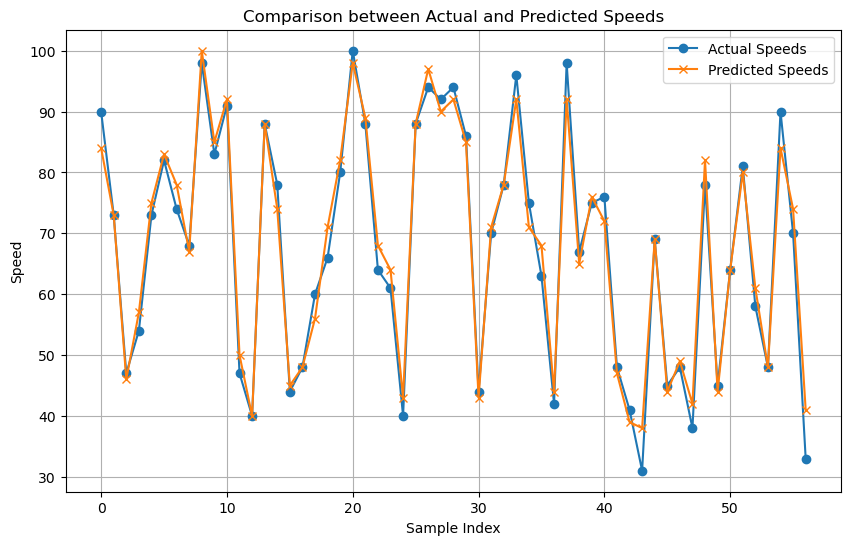

In [87]:
plt.figure(figsize=(10, 6))
plt.plot(all_real_speeds, label='Actual Speeds', marker='o')
plt.plot(all_predicted_speeds, label='Predicted Speeds', marker='x')

plt.title('Comparison between Actual and Predicted Speeds')
plt.xlabel('Sample Index')
plt.ylabel('Speed')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

MAE: 2.3859649122807016
RMSE: 3.077935056255462
R^2: 0.9748539685159723


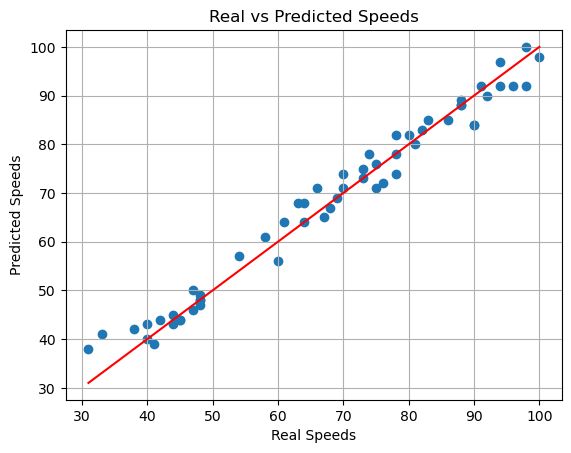

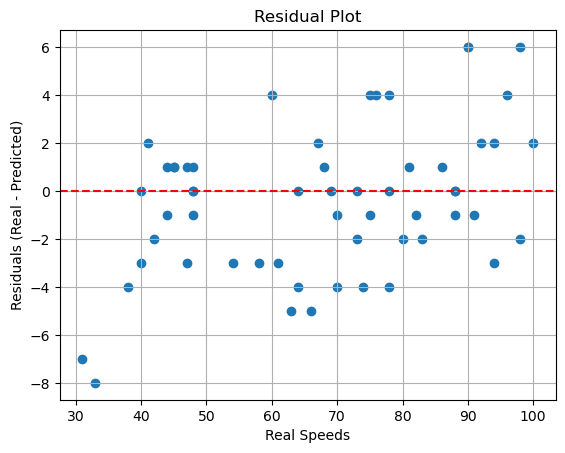

In [88]:
error = all_real_speeds - all_predicted_speeds
mae = mean_absolute_error(all_real_speeds, all_predicted_speeds)
print(f'MAE: {mae}')
rmse = np.sqrt(mean_squared_error(all_real_speeds, all_predicted_speeds))
print(f'RMSE: {rmse}')
r2 = r2_score(all_real_speeds, all_predicted_speeds)
print(f'R^2: {r2}')
plt.scatter(all_real_speeds, all_predicted_speeds)
plt.plot([min(all_real_speeds), max(all_real_speeds)], [min(all_real_speeds), max(all_real_speeds)], color='red')  # Line y=x
plt.xlabel('Real Speeds')
plt.ylabel('Predicted Speeds')
plt.title('Real vs Predicted Speeds')
plt.grid(True)
plt.show()
residuals = all_real_speeds - all_predicted_speeds
plt.scatter(all_real_speeds, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Real Speeds')
plt.ylabel('Residuals (Real - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

In [54]:
reproduce_video_from_np(data_loader.data_real_image[27])

In [55]:
data_loader.data_real_speed[27]

92.0

In [56]:
eval_data = torch.tensor(data_loader.data_real_image[27], dtype=torch.float32).permute(3, 0, 1, 2).unsqueeze(0).to(device)
with torch.no_grad():
    test_output = best_model(eval_data)
torch.round(test_output).int()

tensor([[90]], device='cuda:0', dtype=torch.int32)

In [57]:
reproduce_video_from_np(data_loader.data_real_image[14])

In [58]:
data_loader.data_real_speed[14]

78.0

In [59]:
eval_data = torch.tensor(data_loader.data_real_image[2], dtype=torch.float32).permute(3, 0, 1, 2).unsqueeze(0).to(device)
with torch.no_grad():
    test_output = best_model(eval_data)
torch.round(test_output).int()

tensor([[46]], device='cuda:0', dtype=torch.int32)

In [60]:
reproduce_video_from_np(data_loader.data_real_image[2])

In [61]:
data_loader.data_real_speed[2]

47.0

In [62]:
eval_data = torch.tensor(data_loader.data_real_image[2], dtype=torch.float32).permute(3, 0, 1, 2).unsqueeze(0).to(device)
with torch.no_grad():
    test_output = best_model(eval_data)
torch.round(test_output).int()

tensor([[46]], device='cuda:0', dtype=torch.int32)

In [63]:
reproduce_video_from_np(data_loader.data_real_image[4])

In [64]:
data_loader.data_real_speed[4]

73.0

In [65]:
eval_data = torch.tensor(data_loader.data_real_image[4], dtype=torch.float32).permute(3, 0, 1, 2).unsqueeze(0).to(device)
with torch.no_grad():
    test_output = best_model(eval_data)
torch.round(test_output).int()

tensor([[75]], device='cuda:0', dtype=torch.int32)

In [66]:
eval_data = torch.tensor(data_loader.data_real_image[4], dtype=torch.float32).permute(3, 0, 1, 2).unsqueeze(0).to(device)
with torch.no_grad():
    test_output = best_model(eval_data)
torch.round(test_output).int()

tensor([[75]], device='cuda:0', dtype=torch.int32)